# 1 Verifying the existing of GPU

In [28]:
!nvidia-smi

Fri Jun  7 07:18:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0              27W /  70W |   8423MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# 2 Downloading the dataset

In [32]:
%%shell
rm -rf ./animals10small/
pip3 -q install --upgrade --no-cache-dir gdown
gdown -q 1Do8SXKm4rmXW-phHlejV-udLfhSyYgKk
echo 'download: done => file: animals10small.zip'
rm -rf ./animals10small.zip/
unzip -q animals10small.zip
echo 'Data files in: /content/animals10small/'

download: done => file: animals10small.zip
Data files in: /content/animals10small/


# 3 Importing libraries

In [1]:
import tensorflow as tf
import tensorflow.keras.utils as utils
import tensorflow.keras.applications as app
from tensorflow.keras.applications.imagenet_utils import decode_predictions

#Classification models
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1
from tensorflow.keras.applications import VGG16, ResNet50, ResNet50V2, InceptionV3, Xception, ResNet152, ResNet152V2, MobileNetV3Large, MobileNetV3Small

import numpy as np
import matplotlib.pyplot as plt
import os




SyntaxError: invalid syntax (<ipython-input-1-277a7495c9e4>, line 13)

# 4 Defining functions

In [52]:
# Use pre-train model as backbone
# include_top = True to get all of layers in backbone
# include_top = False to get all of layers but freeze FC(Dense and Softmax) in backbone

loaded_models = {
    "VGG16": VGG16(include_top=True, input_shape=(224,224,3), weights='imagenet'),
    "ResNet50": ResNet50(include_top=True, input_shape=(224,224,3), weights='imagenet'),
    "InceptionV3": InceptionV3(include_top=True, input_shape=(299,299,3), weights='imagenet'),
}
preprocess_methods = {
    "VGG16":app.vgg16.preprocess_input,
    "ResNet50":app.resnet50.preprocess_input,
    "InceptionV3":app.inception_v3.preprocess_input,
}
input_size = {
    "VGG16":(224,224),
    "ResNet50":(224,224),
    "InceptionV3":(299,299),
}

def imagenet_labels(datafile: str='imagenet_classes.txt'):
  import ast
  with open(datafile, 'r') as file:
      data = file.read()
  LK = ast.literal_eval(data)
  return LK

def classify(model_name, batch):
  model = loaded_models[model_name]
  preprocess = preprocess_methods[model_name]
  batch = preprocess(batch)
  print("length of batch: ", len(batch))
  probs = model.predict(batch)
  print(probs)

  return probs

def load_data(batch_files, model_name):
  # read image in keras by utils
  batch_images = [utils.img_to_array(utils.load_img(file, target_size=input_size[model_name])) for file in batch_files]
  # 1 image (H,W,C) --expand dim--> N image (N,H,W,C)
  batch_images = [np.expand_dims(image, axis=0) for image in batch_images]
  batch_images = np.concatenate(batch_images, axis=0)
  return batch_images




# 5 Predicting for image files

1/1 [==============================] - 0s 218ms/step


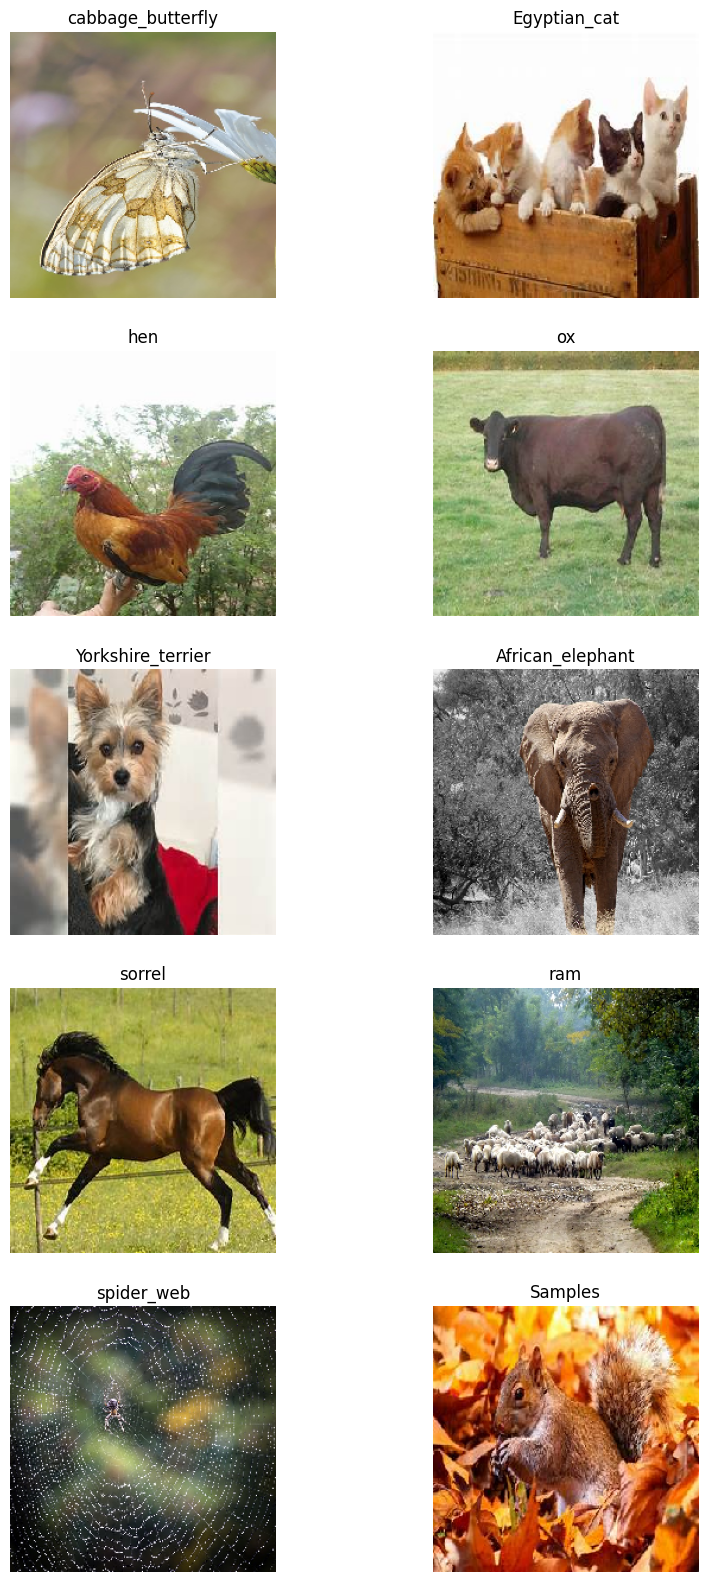

In [38]:
path_to_data = 'animals10small/data'
model_name = "InceptionV3" # change here for each model
batch_files = ['butterfly/e030b20928e90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg',
               'cat/10.jpeg',
               'chicken/102.jpeg',
               'cow/OIP--2ix__438O7A-yHzROPhGwHaFj.jpeg',
               'dog/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg',
               'elephant/e131b0072ee90021d85a5854ee454296eb70e3c818b413449df1c27ba6ee_640.jpg',
               'horse/OIP---MGqQIhmz3OEPYP-46_xwHaFj.jpeg',
               'sheep/e032b5082ef61c22d2524518b7444f92e37fe5d404b0144390f8c078a0eabd_640.jpg',
               'spider/e03db4072cf01c22d2524518b7444f92e37fe5d404b0144390f8c47ba6edbc_640.jpg',
               'squirrel/OIP--2DLJjX4d5SG0eF_EXsO9AHaEk.jpeg'
               ]

###
batch_files = [os.path.join(path_to_data, file) for file in batch_files]

# Load images, classify and decode the output
batch_data = load_data(batch_files, model_name)
probs = classify(model_name, batch_data)
labels = decode_predictions(probs, top=1)
labels = [label[0][1] for label in labels]

plt.figure(figsize=(10,20))
for i in range(10):
  file = batch_files[i]
  image = utils.img_to_array(utils.load_img(file, target_size=(224,224))).astype('uint8')
  ax = plt.subplot(5,2,i+1)
  ax.imshow(image)
  ax.set_title(labels[i])
  ax.axis('off')
plt.title("Samples")
plt.show()

#5.1 Determining labels from predicted probabilitics

In [41]:
label_file = "./animals10small/imagenet-labels.txt"
IDX2LABEL = imagenet_labels(label_file)
pred, score = probs.argmax(axis=-1), probs.max(axis=1)
pred = [IDX2LABEL[idx] for idx in pred]
labels = tuple(zip(pred, (100*score).tolist()))

results = dict(zip(batch_files, labels))
for key in results.keys():
  print(key, results[key])

animals10small/data/butterfly/e030b20928e90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg ('cabbage butterfly', 73.53424072265625)
animals10small/data/cat/10.jpeg ('Egyptian cat', 17.430126190185547)
animals10small/data/chicken/102.jpeg ('hen', 36.64805221557617)
animals10small/data/cow/OIP--2ix__438O7A-yHzROPhGwHaFj.jpeg ('ox', 73.88642120361328)
animals10small/data/dog/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg ('Yorkshire terrier', 63.68778991699219)
animals10small/data/elephant/e131b0072ee90021d85a5854ee454296eb70e3c818b413449df1c27ba6ee_640.jpg ('African elephant, Loxodonta africana', 69.40059661865234)
animals10small/data/horse/OIP---MGqQIhmz3OEPYP-46_xwHaFj.jpeg ('sorrel', 66.8862075805664)
animals10small/data/sheep/e032b5082ef61c22d2524518b7444f92e37fe5d404b0144390f8c078a0eabd_640.jpg ('ram, tup', 24.48907470703125)
animals10small/data/spider/e03db4072cf01c22d2524518b7444f92e37fe5d404b0144390f8c47ba6edbc_640.jpg ("spider web, spider's web", 92.32160186767578)
animals10small/data/

#Using image_dataset_from_directory

Reference:


*   [https://www.tensorflow.org/tutorials/load_data/images?hl=en](https://www.tensorflow.org/tutorials/load_data/images?hl=en)




In [42]:
data_path = './animals10small/data'
dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    image_size=(224, 224),
    batch_size=16,
    shuffle=True
)


Found 1000 files belonging to 10 classes.


In [43]:
dataset.class_names

['butterfly',
 'cat',
 'chicken',
 'cow',
 'dog',
 'elephant',
 'horse',
 'sheep',
 'spider',
 'squirrel']

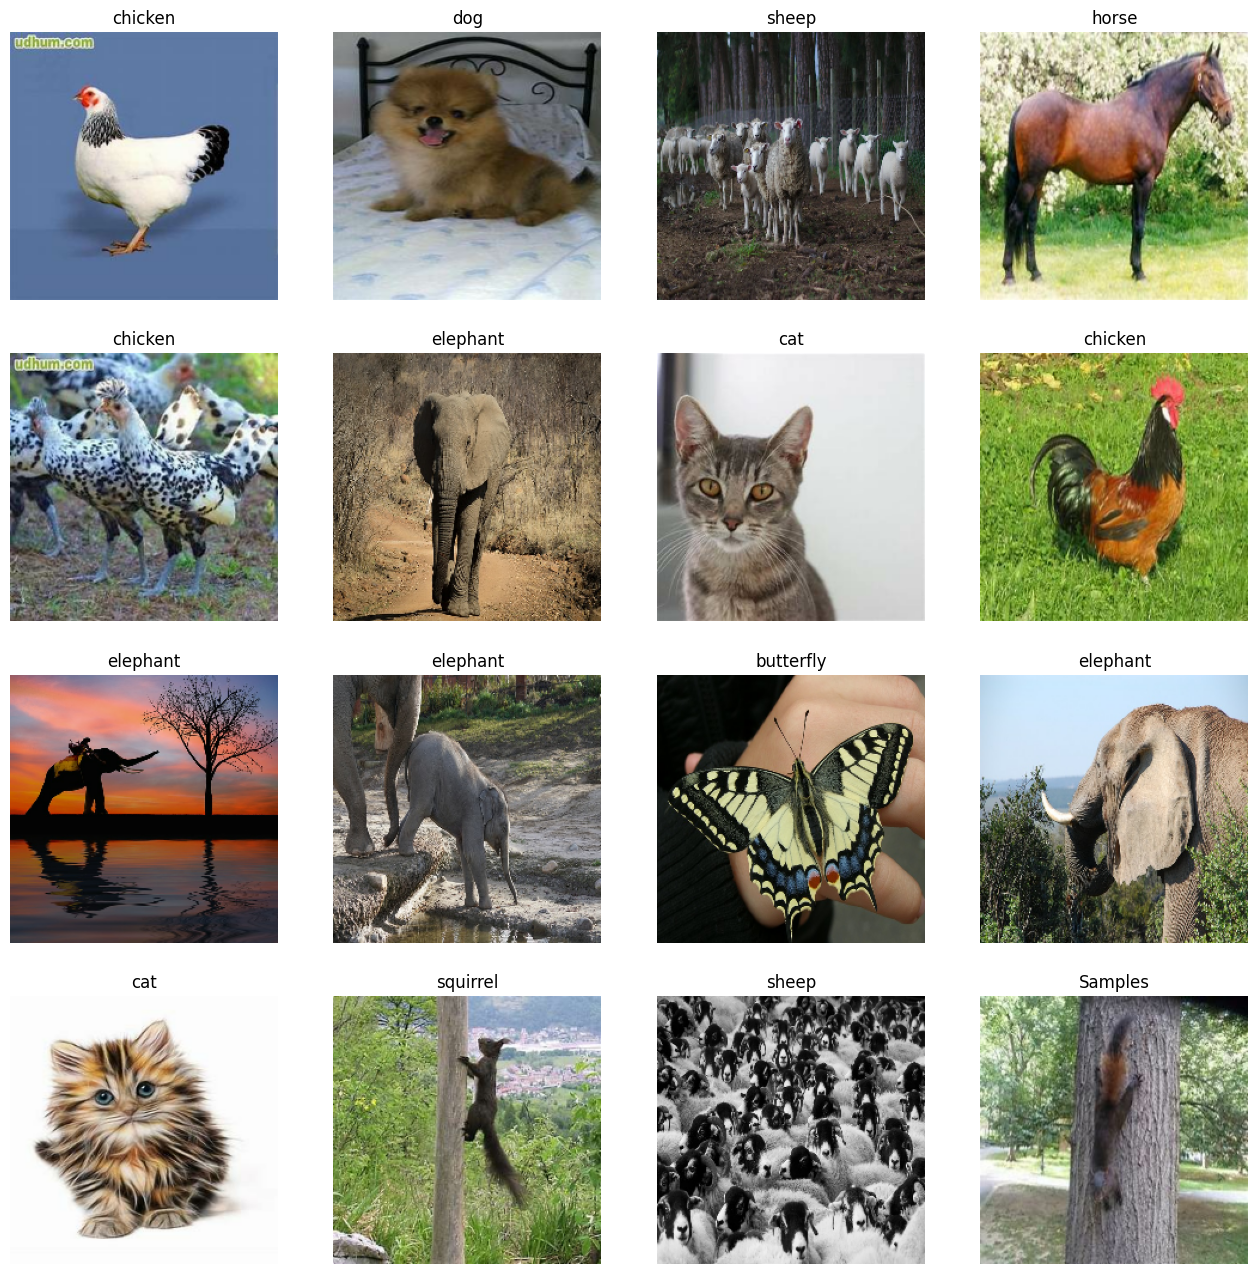

In [44]:
plt.figure(figsize=(16,16))
for images, labels in dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    ax.imshow(images[i].numpy().astype("uint8"))
    ax.set_title(dataset.class_names[labels[i]])
    ax.axis("off")
plt.title("Samples")
plt.show()

# Optimization code


length of batch:  16
1/1 [==============================] - 0s 30ms/step
[[6.2741532e-07 1.2564814e-06 4.9002473e-08 ... 8.3982906e-07
  8.3357096e-05 4.4550679e-06]
 [7.0925635e-06 1.7321494e-07 8.5684150e-07 ... 2.4466598e-07
  8.0370501e-06 2.2708641e-06]
 [2.9679970e-06 1.0793591e-07 5.4196749e-07 ... 2.9516860e-07
  2.3247041e-05 2.1295727e-07]
 ...
 [3.0788760e-09 1.5268303e-10 1.8760220e-09 ... 5.2223167e-11
  2.7372096e-08 1.1752819e-09]
 [2.6310701e-10 8.8704804e-09 7.7614720e-10 ... 2.5428604e-09
  5.6200626e-08 1.5336574e-09]
 [6.9290094e-05 1.0184434e-05 8.0137573e-07 ... 1.5059579e-06
  1.1203445e-05 2.4126069e-07]]
[326 345 351 236 690 291 730 323 348 104 265 386 285 386 321 270] [0.7150598  0.5982323  0.71590227 0.9111909  0.50950956 0.16155149
 0.1475605  0.53532547 0.98147917 0.7134229  0.8491707  0.68066365
 0.20291677 0.9087998  0.9589851  0.84607136]
['lycaenid, lycaenid butterfly', 'ox', 'hartebeest', 'Doberman, Doberman pinscher', 'oxcart', 'lion, king of beasts, 

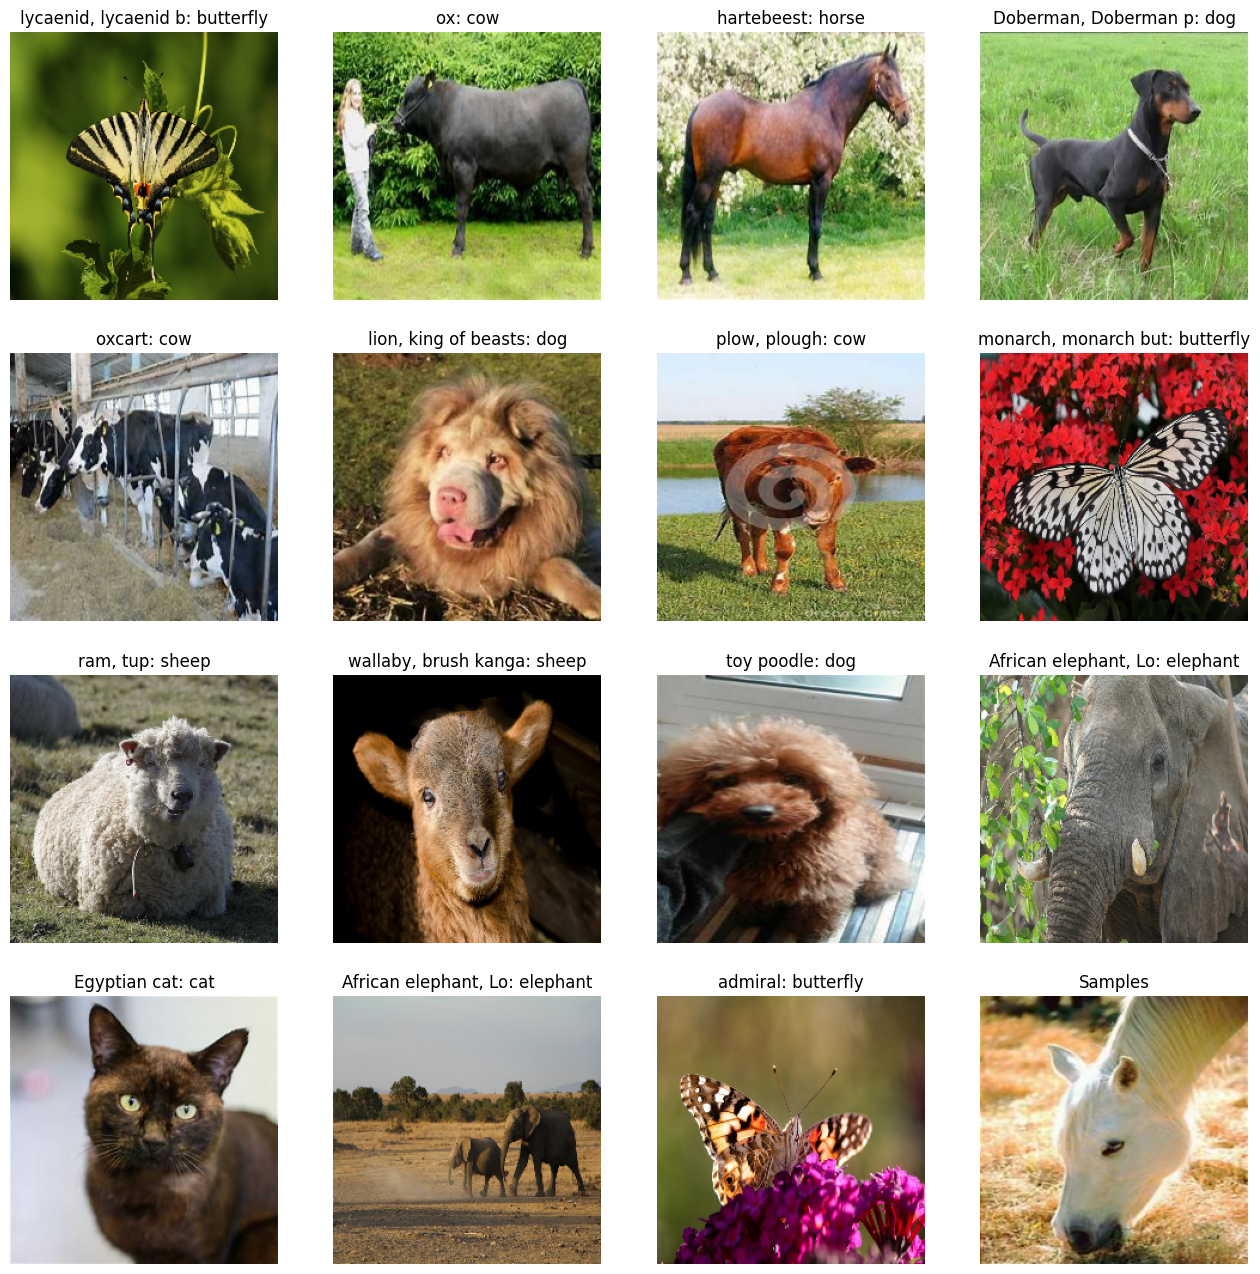

In [58]:
model_name = "ResNet50"
plt.figure(figsize=(16,16))
for images, labels in dataset.take(1):
  probs = classify(model_name, images)
  pred = probs.argmax(axis=-1)
  print(probs.argmax(axis=-1), probs.max(axis=1))
  pred = [IDX2LABEL[idx] for idx in pred]
  print(pred)
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    ax.imshow(images[i].numpy().astype("uint8"))
    ax.set_title(pred[i][:20] + ": " + dataset.class_names[labels[i]])
    ax.axis("off")
plt.title("Samples")
plt.show()